# Contact Graph Generator

In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE

import numpy as np
from copy import deepcopy


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
# logging.getLogger().setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

## Simple Demo 2

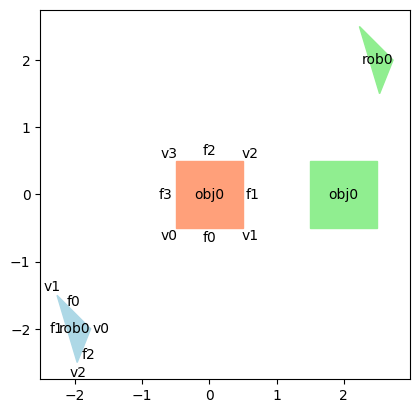

In [2]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
# generator.generate()

In [4]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Loading 11 contact pair modes for 2 bodies...


INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 662.70it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 6045.01it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 6005.06it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 6343.55it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 52/52 [00:00<00:00, 4650.30it/s]
INFO:large_gcs.graph.graph:Adding 52 edges to graph...
100%|██████████| 52/52 [00:00<00:00, 4275.46it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=52, source=[array([0, 0]), array([-2, -2])], target=[array([2, 0]), array([2.500, 2.000])], workspace=array([[-3,  3],
       [-3,  3]]), default_costs_constraints=None)


In [5]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    should_reexplore=True,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, should_rexplore: True
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.154, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 2 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 2, vertex_coverage: 0.231, edge_coverage: 0.0192, time_wall_clock: 0.00821, n_gcs_solves: 2, gcs_solve_time_total: 0.00402, gcs_solve_time_iter_mean: 0.00201, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 2.74e-06, gcs_solve_time_iter_min: 0.00201, gcs_solve_time_iter_max: 0.00201, n_vert

In [6]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_under)
gcs_astar = GcsAstar(
    cg,
    cost_estimator=cost_estimator,
    use_convex_relaxation=False,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.154, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 2 neighbors (0)


INFO:large_gcs.algorithms.gcs_astar:
n_vertices_visited: 3, n_edges_visited: 2, n_vertices_explored: 2, vertex_coverage: 0.231, edge_coverage: 0.0385, time_wall_clock: 0.0276, n_gcs_solves: 2, gcs_solve_time_total: 0.00705, gcs_solve_time_iter_mean: 0.00353, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0.00195, gcs_solve_time_iter_min: 0.00158, gcs_solve_time_iter_max: 0.00547, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node ('NC|obj0_f0-rob0_v1',)'s 6 neighbors (8.34428877816914)
INFO:large_gcs.algorithms.gcs_astar:
n_vertices_visited: 4, n_edges_visited: 6, n_vertices_explored: 7, vertex_coverage: 0.308, edge_coverage: 0.115, time_wall_clock: 0.11, n_gcs_solves: 7, gcs_solve_time_total: 0.0379, gcs_solve_time_iter_mean: 0.00541, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0.00471, gcs_solve_time_iter_min: 0.00158, gcs_solve_time_iter_max: 0.0156, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node ('NC|obj0_f3-rob0_v0',)'

In [ ]:
sol = cg.solve(use_convex_relaxation=False)
print(sol)

In [ ]:
sol = cg.solve(use_convex_relaxation=True)
print(sol)

## Triangle Challenge 2

In [ ]:
ws_x = 4
ws_y = 3
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
# generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

Just checking that everything works

In [ ]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    should_reexplore=True,
)
sol = gcs_astar.run()

In [ ]:
ws_x = 4
ws_y = 3
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
ws_x = 4
ws_y = 3
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
ws_x = 4
ws_y = 3
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
obj_only_params = deepcopy(params)
obj_only_params.name = "cg_maze_a2_obj_only"
obj_only_params.rob_vertices = []
obj_only_params.source_rob_pos = []
obj_only_params.target_rob_pos = []
generator = ContactGraphGenerator(obj_only_params)
generator.plot()